# Incumplimiento de los clientes de tarjetas de crédito

**Shirley Bermudez Tirado, **
**Milton Anderson Ramírez Hoyos**   
Universidad Nacional de Colombia, Sede Medellín   
Facultad de Minas   
Medellín, Colombia

---


# Fuente de los datos

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients 
Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

# Repositorio en Github

https://github.com/miaramirezho/Ddefault-credit-card

# Contenido

1) **Definición del problema real** <br>
2) **Definición del problema en términos de los datos**<br>
3) **Exploración de los datos**<br>
4) **Preparación de los datos**<br>
5) **Entrenamiento de los modelos**<br>
6) **Evaluación**<br>

# 1) Definición del problema real

Se tiene una base de datos en la cual se recopiló el comportamiento para determinadas variables de un grupo de clientes de tarjetas de créditos en Taiwán, adicionalmente se recopilaron las características principales de dichos clientes. La base de datos como tal es el resultado del esfuerzo realizado para predecir si un cliente pagará o no la próxima cuota de su tarjeta de crédito, con la probabilidad real de incumplimiento como la variable de respuesta (Y) y la probabilidad predictiva de incumplimiento como la variable independiente (X).

# 2) Definición del problema en terminos de los datos

Se cuenta con una muestra de 30000 ejemplos y 25 variables que describen las caracteristicas de los clientes y su comportamiento de pago en el tiempo.

A continuaciòn se describen en su respectivo orden las variables que incluye el set de datos. Si bien en esta parte del texto se indicarà el nombre de las variables en español, se respetará el nombre original de las variables el cual viene en inglés, se hace la traducciòn para brindar mayor claridad al lector:

* ID: Identificación del cliente
* Monto otorgado: Valor del crédito adquirido
* Sexo: 1 = hombre, 2 = mujer
* Educación: Nivel de escolaridad 1 = escuela de postgrado, 2 = universidad, 3 = escuela secundaria, 4 = otros)
* Estado civil: (1 = casado, 2 = soltero, 3 = otros)
* Edad: (en años)
* Pago 0 a Pago 5: Historial de pagos anteriores de abril a septiembre de 2005
* Saldo 0 a Saldo 5: Saldo de la obligación crediticia de abril a septiembre de 2005
* PagoAnt 0 a PagoAnt5: Importe del pago anterior de abril a septiembre de 2005
* Incumplimiento en pago al siguiente mes : 1: se espera incumplimiento en el pago de la obligación, 0: e espera un pago a tiempo. 

Esta última será la variable clasificadora.

# 3) Exploración de los datos

In [1]:
# Se cargan las librerías necesarias para el análisis

library(class) # para el KNN
library(psych)
library(C50)
library(gmodels)
library(caret)
library(doSNOW)
library(dplyr)
library(ggplot2)

Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha

Loading required package: foreach
Loading required package: iterators
Loading required package: snow

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [2]:
# Código para paralelizar
cl <- makeCluster(3, type = "SOCK")

# Register cluster so that caret will know to train in parallel.
registerDoSNOW(cl)

In [4]:
# Se lee el archivo y se convierten en factores las variables categoricas
#filename = "C:\\Users\\PROYECTOS_54\\Analitica\\default of credit card clients.csv"
data <- read.csv('default of credit card clients.csv', sep=';')
data <- data[,2:25] # se elimina la variable ID que esta en la columna 1

data$default.payment.next.month <- as.factor(data$default.payment.next.month)
data$SEX <- as.factor(data$SEX)
data$EDUCATION <- as.factor(data$EDUCATION)
data$MARRIAGE <- as.factor(data$MARRIAGE)
data$PAY_0 <- as.factor(data$PAY_0)
data$PAY_2 <- as.factor(data$PAY_2)
data$PAY_3 <- as.factor(data$PAY_3)
data$PAY_4 <- as.factor(data$PAY_4)
data$PAY_5 <- as.factor(data$PAY_5)
data$PAY_6 <- as.factor(data$PAY_6)
str(data)

'data.frame':	30000 obs. of  24 variables:
 $ LIMIT_BAL                 : int  20000 120000 90000 50000 50000 50000 500000 100000 140000 20000 ...
 $ SEX                       : Factor w/ 2 levels "1","2": 2 2 2 2 1 1 1 2 2 1 ...
 $ EDUCATION                 : Factor w/ 7 levels "0","1","2","3",..: 3 3 3 3 3 2 2 3 4 4 ...
 $ MARRIAGE                  : Factor w/ 4 levels "0","1","2","3": 2 3 3 2 2 3 3 3 2 3 ...
 $ AGE                       : int  24 26 34 37 57 37 29 23 28 35 ...
 $ PAY_0                     : Factor w/ 11 levels "-2","-1","0",..: 5 2 3 3 2 3 3 3 3 1 ...
 $ PAY_2                     : Factor w/ 11 levels "-2","-1","0",..: 5 5 3 3 3 3 3 2 3 1 ...
 $ PAY_3                     : Factor w/ 11 levels "-2","-1","0",..: 2 3 3 3 2 3 3 2 5 1 ...
 $ PAY_4                     : Factor w/ 11 levels "-2","-1","0",..: 2 3 3 3 3 3 3 3 3 1 ...
 $ PAY_5                     : Factor w/ 10 levels "-2","-1","0",..: 1 3 3 3 3 3 3 3 3 2 ...
 $ PAY_6                     : Factor w/ 10 levels

In [5]:
names(data)

[1] "LIMIT_BAL"                  "SEX"                       
 [3] "EDUCATION"                  "MARRIAGE"                  
 [5] "AGE"                        "PAY_0"                     
 [7] "PAY_2"                      "PAY_3"                     
 [9] "PAY_4"                      "PAY_5"                     
[11] "PAY_6"                      "BILL_AMT1"                 
[13] "BILL_AMT2"                  "BILL_AMT3"                 
[15] "BILL_AMT4"                  "BILL_AMT5"                 
[17] "BILL_AMT6"                  "PAY_AMT1"                  
[19] "PAY_AMT2"                   "PAY_AMT3"                  
[21] "PAY_AMT4"                   "PAY_AMT5"                  
[23] "PAY_AMT6"                   "default.payment.next.month"

In [6]:
head(data)
# describe(data)

LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0


In [7]:
# Se Verifica que los datos esten completos (Sin NAs)
table(complete.cases(data))


 TRUE 
30000 

In [8]:
# Se valida la proporción de los datos para cada categoría
table(data$default.payment.next.month)


    0     1 
23364  6636 

In [9]:
# Se contabilizan la cantidad de columnas y filas que tiene el dataset
dim(data)

[1] 30000    24

In [10]:
# Se examina el rango de las variables
summary(data)

   LIMIT_BAL       SEX       EDUCATION MARRIAGE       AGE       
 Min.   :  10000   1:11888   0:   14   0:   54   Min.   :21.00  
 1st Qu.:  50000   2:18112   1:10585   1:13659   1st Qu.:28.00  
 Median : 140000             2:14030   2:15964   Median :34.00  
 Mean   : 167484             3: 4917   3:  323   Mean   :35.49  
 3rd Qu.: 240000             4:  123             3rd Qu.:41.00  
 Max.   :1000000             5:  280             Max.   :79.00  
                             6:   51                            
     PAY_0           PAY_2           PAY_3           PAY_4      
 0      :14737   0      :15730   0      :15764   0      :16455  
 -1     : 5686   -1     : 6050   -1     : 5938   -1     : 5687  
 1      : 3688   2      : 3927   -2     : 4085   -2     : 4348  
 -2     : 2759   -2     : 3782   2      : 3819   2      : 3159  
 2      : 2667   3      :  326   3      :  240   3      :  180  
 3      :  322   4      :   99   4      :   76   4      :   69  
 (Other):  141   (Other):

In [11]:
# Se separa la variable clasificadora 
default <- data$default.payment.next.month

# Se crea el conjunto con las variables de entrenamiento sin la columna ID, ni la clasificadora
X <- data[,1:23] # Variables numericas sin escalar


X_cat <- X[,c(2:4,6:11)] # Variables categoricas
X_num <- X[,c(1,5,12:23)] # Variables Numericas


In [12]:
## Se convierte la columna default.payment.next.month a factor con etiquetas.
default <- factor(default,
            levels=c('0', '1'),
            labels= c('Pagará', 'No_pagará'))

head(default)

[1] No_pagará No_pagará Pagará    Pagará    Pagará    Pagará   
Levels: Pagará No_pagará

In [13]:
# Proporción de la clasificación
round(prop.table(table(default))*100, digits =2)

default
   Pagará No_pagará 
    77.88     22.12 

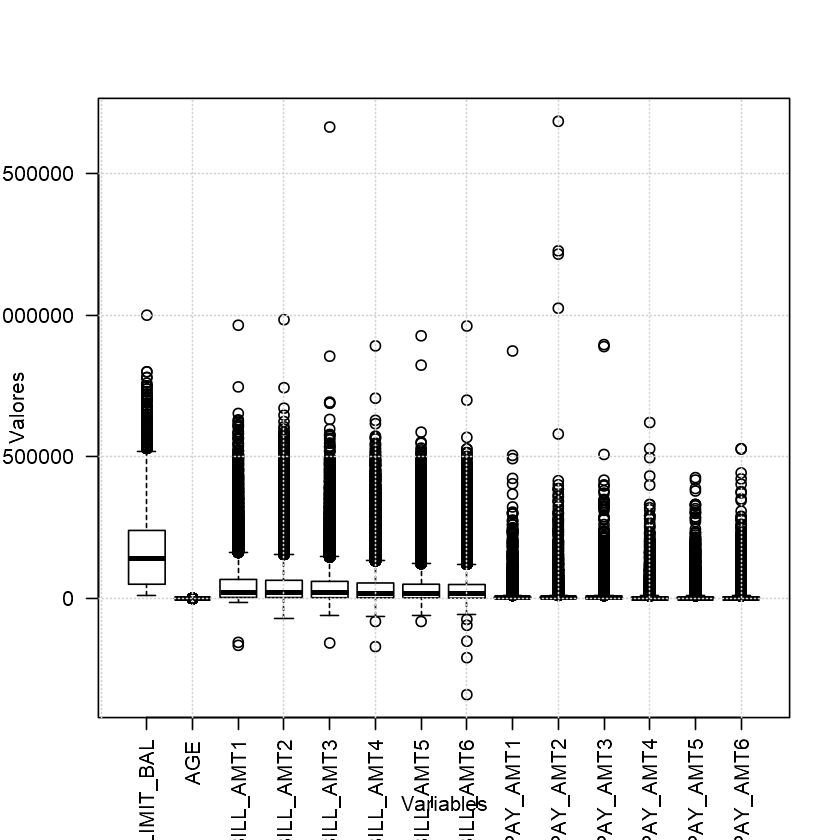

In [14]:
#boxplot(data)
plt <- boxplot(X_num, 
               xlab="Variables", 
               ylab="Valores",
               srt = 90,
               horiz=FALSE,
               las=2)
grid()

Como se puede apreciar en el boxplot y en los estadísticos básicos, dada la gran diferencia en los rangos entre los cuales fluctúan cada uno de los datos de las variables, se realizará un proceso de escalamiento en la siguiente sección.

# 4) Preparación de los datos

In [15]:
# Se valida el encabezado para las variables que conforman el set de X

head(X_num)

LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0
120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679
50000,37,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800


In [16]:
# Se define la función de normalización

MinMaxEscaler <-
function(x) {
    return ((x - min(x)) / (max(x) - min(x)))
}

# Se aplica la función a los datos

X_num <- as.data.frame(lapply(X_num, MinMaxEscaler))

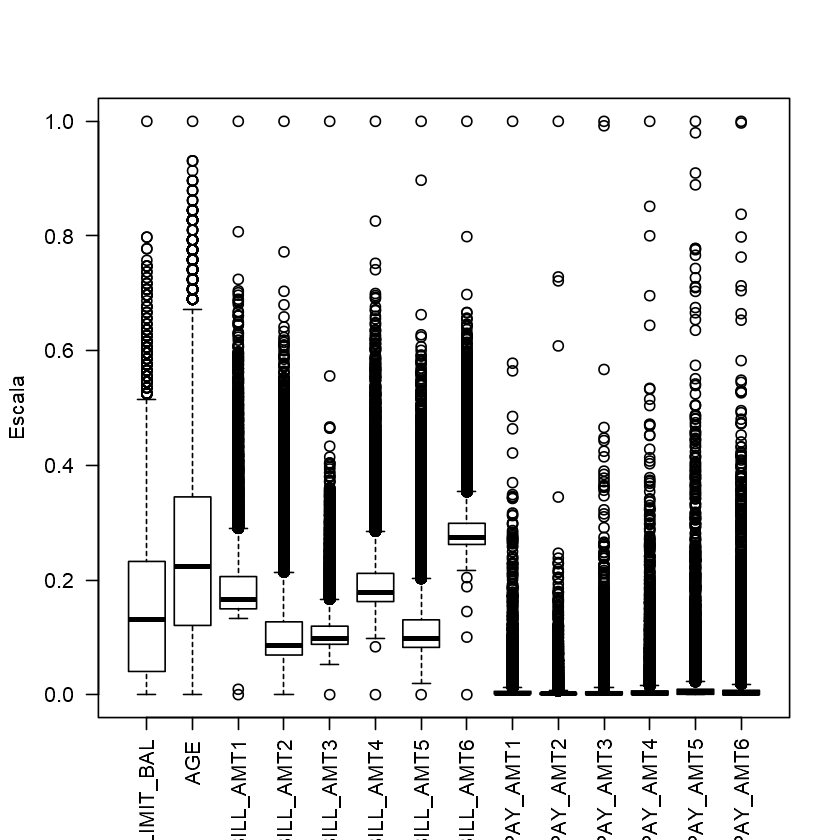

In [17]:
boxplot(X_num, 
        ylab= 'Escala', 
        srt= 90, 
        horiz= FALSE, 
        las= 2)

Ahora, el nuevo boxplot permite validar que todos los valores que asumen las variables que conforman el objeto X, varían en un el mismo intervalo.

In [18]:
# Se crea objeto con variables categoricas y numéricas ya escaladas

X_scaled <- cbind(X_cat, X_num)
dim(X_scaled)

[1] 30000    23

In [19]:
# Se validan los estadísticos básicos para todas las variables que conforman el objeto X 
# tanto numéricas como categóricas

summary(X_scaled)

 SEX       EDUCATION MARRIAGE      PAY_0           PAY_2           PAY_3      
 1:11888   0:   14   0:   54   0      :14737   0      :15730   0      :15764  
 2:18112   1:10585   1:13659   -1     : 5686   -1     : 6050   -1     : 5938  
           2:14030   2:15964   1      : 3688   2      : 3927   -2     : 4085  
           3: 4917   3:  323   -2     : 2759   -2     : 3782   2      : 3819  
           4:  123             2      : 2667   3      :  326   3      :  240  
           5:  280             3      :  322   4      :   99   4      :   76  
           6:   51             (Other):  141   (Other):   86   (Other):   78  
     PAY_4           PAY_5           PAY_6         LIMIT_BAL     
 0      :16455   0      :16947   0      :16286   Min.   :0.0000  
 -1     : 5687   -1     : 5539   -1     : 5740   1st Qu.:0.0404  
 -2     : 4348   -2     : 4546   -2     : 4895   Median :0.1313  
 2      : 3159   2      : 2626   2      : 2766   Mean   :0.1591  
 3      :  180   3      :  178   3    

In [20]:
# Crear objeto con las variables categoricas, la clasificadora y las variables numericas escaladas

X_scaled <- cbind(X_cat, X_num, default)
str(X_scaled)
dim(X_scaled)

'data.frame':	30000 obs. of  24 variables:
 $ SEX      : Factor w/ 2 levels "1","2": 2 2 2 2 1 1 1 2 2 1 ...
 $ EDUCATION: Factor w/ 7 levels "0","1","2","3",..: 3 3 3 3 3 2 2 3 4 4 ...
 $ MARRIAGE : Factor w/ 4 levels "0","1","2","3": 2 3 3 2 2 3 3 3 2 3 ...
 $ PAY_0    : Factor w/ 11 levels "-2","-1","0",..: 5 2 3 3 2 3 3 3 3 1 ...
 $ PAY_2    : Factor w/ 11 levels "-2","-1","0",..: 5 5 3 3 3 3 3 2 3 1 ...
 $ PAY_3    : Factor w/ 11 levels "-2","-1","0",..: 2 3 3 3 2 3 3 2 5 1 ...
 $ PAY_4    : Factor w/ 11 levels "-2","-1","0",..: 2 3 3 3 3 3 3 3 3 1 ...
 $ PAY_5    : Factor w/ 10 levels "-2","-1","0",..: 1 3 3 3 3 3 3 3 3 2 ...
 $ PAY_6    : Factor w/ 10 levels "-2","-1","0",..: 1 4 3 3 3 3 3 2 3 2 ...
 $ LIMIT_BAL: num  0.0101 0.1111 0.0808 0.0404 0.0404 ...
 $ AGE      : num  0.0517 0.0862 0.2241 0.2759 0.6207 ...
 $ BILL_AMT1: num  0.15 0.149 0.172 0.188 0.154 ...
 $ BILL_AMT2: num  0.0692 0.0679 0.0795 0.112 0.0716 ...
 $ BILL_AMT3: num  0.0867 0.0878 0.0938 0.1134 0.106 ...
 $

[1] 30000    24

# Partición aleatoria de los datos

In [21]:
indices <- sample(1:30000, 20000)

X_train <- X_scaled[indices,]
y_train_true <- default[indices]

X_test <- X_scaled[-indices,]
y_test_true <- default[-indices]

In [22]:
set.seed(300)
# Dividir los datos en cunjunto de entrenamiento y prueba con datapartition de caret

indxTrain <- createDataPartition(X_scaled$default,
                                 p = 0.7,
                                 list = FALSE)

training <- X_scaled[indxTrain,]
testing <- X_scaled[-indxTrain,]



# Distribución de la variable clasificadora

Se chequea la distribución de la variable clasificadora en los conjuntos de entrenamiento, test y base de datos original.

El objetivo es procurar que la proporción entre las categorías que se tenía en el data set original, se mantenga en los conjuntos de entrenamiento y prueba.

In [23]:
print("proporción clasificadora en base de datos")
prop.table(table(X_scaled$default)) * 100

print("proporción clasificadora en conjunto de prueba")
prop.table(table(training$default)) * 100

print("proporción clasificadora en testing")
prop.table(table(testing$default)) * 100

[1] "proporción clasificadora en base de datos"



   Pagará No_pagará 
    77.88     22.12 

[1] "proporción clasificadora en conjunto de prueba"



   Pagará No_pagará 
 77.87724  22.12276 

[1] "proporción clasificadora en testing"



   Pagará No_pagará 
 77.88643  22.11357 

Se evidencia una distribución similar en los conjuntos de prueba, test y base de datos completa, para las categorias de la variable clasificadora.

# 5) Entrenamiento de los modelos

Se crea una función para calcular las principales métricas de cada modelo

In [24]:
ingresar <- function (pred){
    # Accuracy
    cm = as.matrix(table(actual = testing$default, Predicted = pred))
    accu = sum(diag(cm))/length(testing$default)
    # Error
    error = 1 - accu
    # Sensitivity
    sensi = sensitivity(pred, testing$default, positive = "Pagará")
    # Especificity
    speci = specificity(pred, testing$default, Positive = "Pagará")
    # PosPredValue
    posPred = posPredValue(pred, testing$default, positive = "Pagará", negative = "No Pagará")
    # NegPredValue
    negPred = negPredValue(pred, testing$default, positive = "Pagará")
    
    # Ingresar indicadores a matrix
    
    return ( fila = c( accu, error, sensi, speci, posPred, negPred))   
}


Se crea una matriz para depositar las principales métricas de cada modelo y así facilitar al final no solo la visualización sino la comparación de los resultados.

In [25]:
metricas = matrix(rep(0, 24), nrow=4, ncol=6, byrow = TRUE)

modelos = c('knn', 'Decisión Tree', 'Random Forest', 'SVM')
indicadores = c('accuracy', 'error', 'sensitivity', 'specificity', 'posPredValue', 'negPredValue')

dimnames(metricas) = list(modelos, indicadores)
metricas

,accuracy,error,sensitivity,specificity,posPredValue,negPredValue
knn,0,0,0,0,0,0
Decisión Tree,0,0,0,0,0,0
Random Forest,0,0,0,0,0,0
SVM,0,0,0,0,0,0


# Entranamiento con cross validation

# 5.1) Método KNN

In [26]:
set.seed(400)
ctrl <- trainControl(method="cv")

In [27]:
knnFit <- train(default ~ ., data = training, method = "knn", trControl = ctrl, tuneLength = 10)

# Salida del kNN ajustado
knnFit

k-Nearest Neighbors 

21001 samples
   23 predictor
    2 classes: 'Pagará', 'No_pagará' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 18901, 18900, 18900, 18901, 18901, 18901, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.7981526  0.3225056
   7  0.8075334  0.3387744
   9  0.8102947  0.3408668
  11  0.8134851  0.3460258
  13  0.8152469  0.3522616
  15  0.8158662  0.3505124
  17  0.8164854  0.3510282
  19  0.8166758  0.3505447
  21  0.8174854  0.3510195
  23  0.8181518  0.3525178

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 23.

In [28]:
# Predicción del modelo
pred_knn <- predict(knnFit, testing)

In [43]:
as.data.frame(pred_knn)

pred_knn
Pagará
Pagará
Pagará
Pagará
Pagará
Pagará
Pagará
Pagará
Pagará
Pagará


In [29]:
# Matriz de confusión y métricas
confusionMatrix(pred_knn, testing$default )

Confusion Matrix and Statistics

           Reference
Prediction  Pagará No_pagará
  Pagará      6692      1358
  No_pagará    317       632
                                          
               Accuracy : 0.8139          
                 95% CI : (0.8057, 0.8219)
    No Information Rate : 0.7789          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3351          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9548          
            Specificity : 0.3176          
         Pos Pred Value : 0.8313          
         Neg Pred Value : 0.6660          
             Prevalence : 0.7789          
         Detection Rate : 0.7436          
   Detection Prevalence : 0.8945          
      Balanced Accuracy : 0.6362          
                                          
       'Positive' Class : Pagará          
                                          

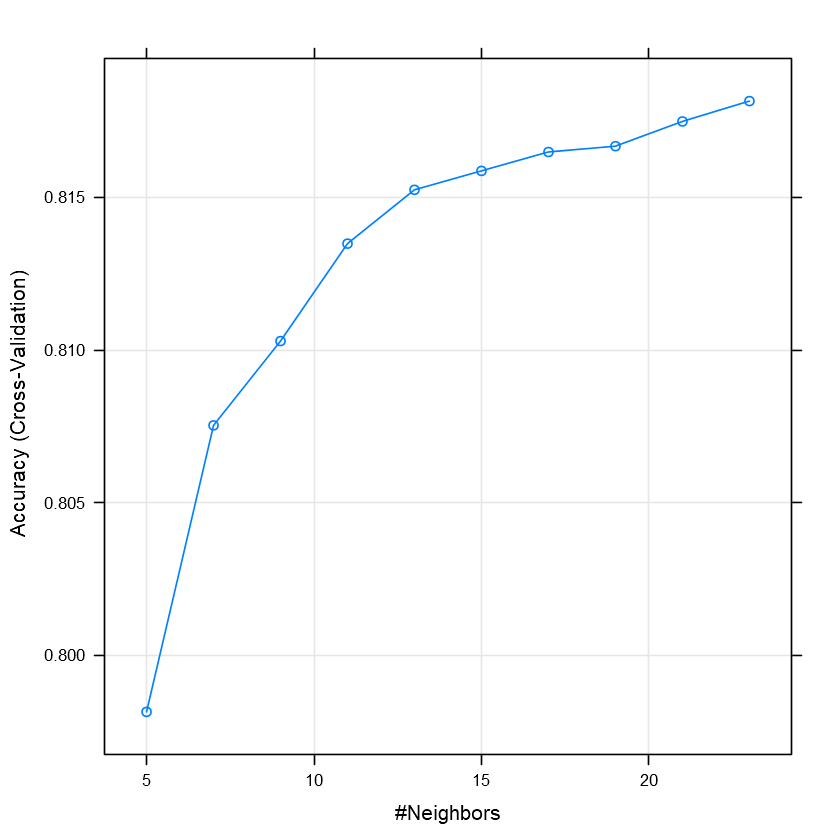

In [30]:
# Plot de los K vecinos y su precisión
plot(knnFit)

In [31]:
# Se ingresan los indicadores del modelo KNN a la matriz métricas

dn = ingresar(pred_knn)
metricas['knn', ] = dn
metricas

,accuracy,error,sensitivity,specificity,posPredValue,negPredValue
knn,0.8138682,0.1861318,0.9547724,0.3175879,0.8313043,0.6659642
Decisión Tree,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
Random Forest,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
SVM,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


# 5.2) Método Decision tree

In [32]:
treeFit <- train(default ~ ., data = training, method = "rpart", trControl = ctrl, tuneLength = 10)

# Salida del Decision tree ajustado
treeFit

CART 

21001 samples
   23 predictor
    2 classes: 'Pagará', 'No_pagará' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 18901, 18901, 18901, 18901, 18901, 18901, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa    
  0.001076195  0.8178657  0.3676575
  0.001147941  0.8182466  0.3660424
  0.001183814  0.8182466  0.3660424
  0.001506672  0.8185798  0.3645300
  0.001721911  0.8191036  0.3630082
  0.002582867  0.8181036  0.3522489
  0.004304778  0.8181989  0.3441939
  0.009470512  0.8180084  0.3450377
  0.011515282  0.8149132  0.3231777
  0.154111063  0.7933915  0.1428786

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.001721911.

In [33]:
# Predicción del modelo

pred_tree <- predict(treeFit, testing)

In [34]:
# Matrix de confusión y métricas

confusionMatrix(pred_tree, testing$default )

Confusion Matrix and Statistics

           Reference
Prediction  Pagará No_pagará
  Pagará      6707      1325
  No_pagará    302       665
                                          
               Accuracy : 0.8192          
                 95% CI : (0.8111, 0.8271)
    No Information Rate : 0.7789          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3567          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9569          
            Specificity : 0.3342          
         Pos Pred Value : 0.8350          
         Neg Pred Value : 0.6877          
             Prevalence : 0.7789          
         Detection Rate : 0.7453          
   Detection Prevalence : 0.8925          
      Balanced Accuracy : 0.6455          
                                          
       'Positive' Class : Pagará          
                                          

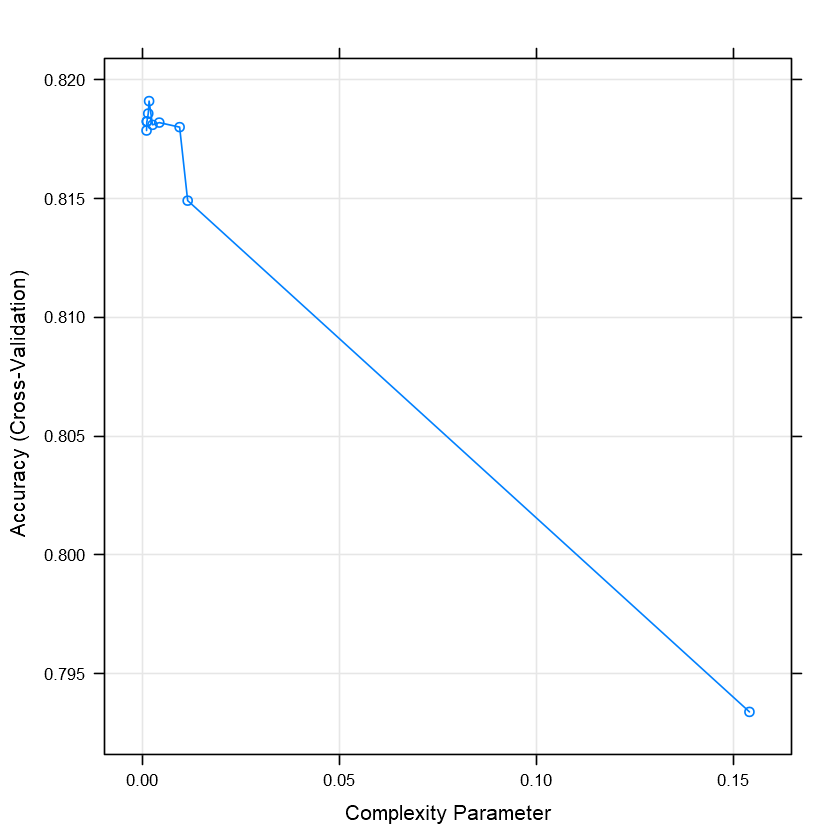

In [35]:
# Plot de los árboles de decisión y su precisión

plot(treeFit)

In [36]:
# Se ingresan las metricas de los árboles de decisión a la matriz métricas

dn = ingresar(pred_tree)
metricas['Decisión Tree', ] = dn
metricas

,accuracy,error,sensitivity,specificity,posPredValue,negPredValue
knn,0.8138682,0.1861318,0.9547724,0.3175879,0.8313043,0.6659642
Decisión Tree,0.8192021,0.1807979,0.9569125,0.3341709,0.8350349,0.6876939
Random Forest,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
SVM,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


# 5.3) Método Random Forest

In [37]:
rfFit <- train(default ~ ., data = training, method = "rpart", trControl = ctrl, tuneLength = 10)

# Salida del modelo Random Forest ajustado
rfFit

CART 

21001 samples
   23 predictor
    2 classes: 'Pagará', 'No_pagará' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 18901, 18901, 18900, 18902, 18902, 18900, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa    
  0.001076195  0.8171514  0.3631965
  0.001147941  0.8172465  0.3639071
  0.001183814  0.8172465  0.3639071
  0.001506672  0.8182463  0.3613426
  0.001721911  0.8181986  0.3614523
  0.002582867  0.8189128  0.3575291
  0.004304778  0.8181516  0.3447427
  0.009470512  0.8181516  0.3467527
  0.011515282  0.8154847  0.3269621
  0.154111063  0.7975324  0.1810645

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.002582867.

In [38]:
# Predicción del modelo

pred_rf <- predict(rfFit, testing)

In [39]:
# Matrix de confusión y métricas

confusionMatrix(pred_rf, testing$default )

Confusion Matrix and Statistics

           Reference
Prediction  Pagará No_pagará
  Pagará      6742      1366
  No_pagará    267       624
                                          
               Accuracy : 0.8185          
                 95% CI : (0.8104, 0.8264)
    No Information Rate : 0.7789          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3434          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9619          
            Specificity : 0.3136          
         Pos Pred Value : 0.8315          
         Neg Pred Value : 0.7003          
             Prevalence : 0.7789          
         Detection Rate : 0.7492          
   Detection Prevalence : 0.9010          
      Balanced Accuracy : 0.6377          
                                          
       'Positive' Class : Pagará          
                                          

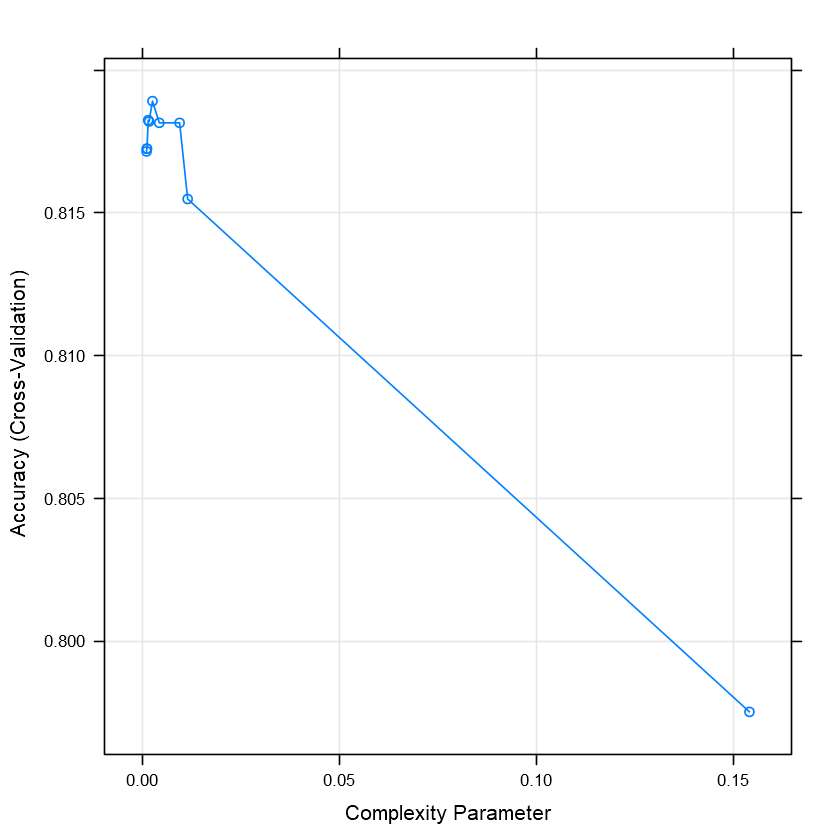

In [40]:
# Plot de los random forest y su precisión
plot(rfFit)

In [41]:
#ingresar metricas de Random Forest a la matrix metricas

dn = ingresar(pred_rf)
metricas['Random Forest', ] = dn
metricas

,accuracy,error,sensitivity,specificity,posPredValue,negPredValue
knn,0.8138682,0.1861318,0.9547724,0.3175879,0.8313043,0.6659642
Decisión Tree,0.8192021,0.1807979,0.9569125,0.3341709,0.8350349,0.6876939
Random Forest,0.8185354,0.1814646,0.9619061,0.3135678,0.8315244,0.7003367
SVM,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


# 5.4) Método SVM

In [47]:

svmFit <- train(default ~ ., data = training, method = "svmLinear", trControl = ctrl, tuneLength = 3)

# Salida del modelo SVM ajustado
svmFit

Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."

Support Vector Machines with Linear Kernel 

21001 samples
   23 predictor
    2 classes: 'Pagará', 'No_pagará' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 18902, 18900, 18900, 18900, 18900, 18902, ... 
Resampling results:

  Accuracy   Kappa   
  0.8196747  0.354842

Tuning parameter 'C' was held constant at a value of 1

In [48]:
# Predicción del modelo

pred_svm <- predict(svmFit, testing)

In [49]:
# Matrix de confusión y métricas

confusionMatrix(pred_svm, testing$default )

Confusion Matrix and Statistics

           Reference
Prediction  Pagará No_pagará
  Pagará      6730      1357
  No_pagará    279       633
                                          
               Accuracy : 0.8182          
                 95% CI : (0.8101, 0.8261)
    No Information Rate : 0.7789          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3452          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9602          
            Specificity : 0.3181          
         Pos Pred Value : 0.8322          
         Neg Pred Value : 0.6941          
             Prevalence : 0.7789          
         Detection Rate : 0.7479          
   Detection Prevalence : 0.8987          
      Balanced Accuracy : 0.6391          
                                          
       'Positive' Class : Pagará          
                                          

In [46]:
#ingresar metricas de SVM a la matrix metricas

dn = ingresar(pred_svm)
metricas['SVM', ] = dn
metricas

,accuracy,error,sensitivity,specificity,posPredValue,negPredValue
knn,0.8138682,0.1861318,0.9547724,0.3175879,0.8313043,0.6659642
Decisión Tree,0.8192021,0.1807979,0.9569125,0.3341709,0.8350349,0.6876939
Random Forest,0.8185354,0.1814646,0.9619061,0.3135678,0.8315244,0.7003367
SVM,0.8182020,0.1817980,0.9601940,0.3180905,0.8321998,0.6940789


# Método Decision Tree con diferentes hiperparámetros

In [52]:
train.control <- trainControl(method = "cv",
                              number = 1,
                              p= 0.7,
                              search = "grid")

tune.grid <- expand.grid(mtry = c(10,20))

In [54]:
set.seed(300)
rfFit_1 <- train(default ~ ., data = training, method = "rf", trControl = ctrl, tuneGrid=tune.grid)

# Salida del Decision Tree ajustado
rfFit_1

Random Forest 

21001 samples
   23 predictor
    2 classes: 'Pagará', 'No_pagará' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 18901, 18902, 18901, 18900, 18902, 18901, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  10    0.8178188  0.3659865
  20    0.8171046  0.3695245

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 10.

In [56]:
# Predicción del modelo
pred_tree <- predict(treeFit, testing)

In [57]:
# Matrix de confusión y métricas
confusionMatrix(pred_tree, testing$default )

Confusion Matrix and Statistics

           Reference
Prediction  Pagará No_pagará
  Pagará      6707      1325
  No_pagará    302       665
                                          
               Accuracy : 0.8192          
                 95% CI : (0.8111, 0.8271)
    No Information Rate : 0.7789          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3567          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9569          
            Specificity : 0.3342          
         Pos Pred Value : 0.8350          
         Neg Pred Value : 0.6877          
             Prevalence : 0.7789          
         Detection Rate : 0.7453          
   Detection Prevalence : 0.8925          
      Balanced Accuracy : 0.6455          
                                          
       'Positive' Class : Pagará          
                                          

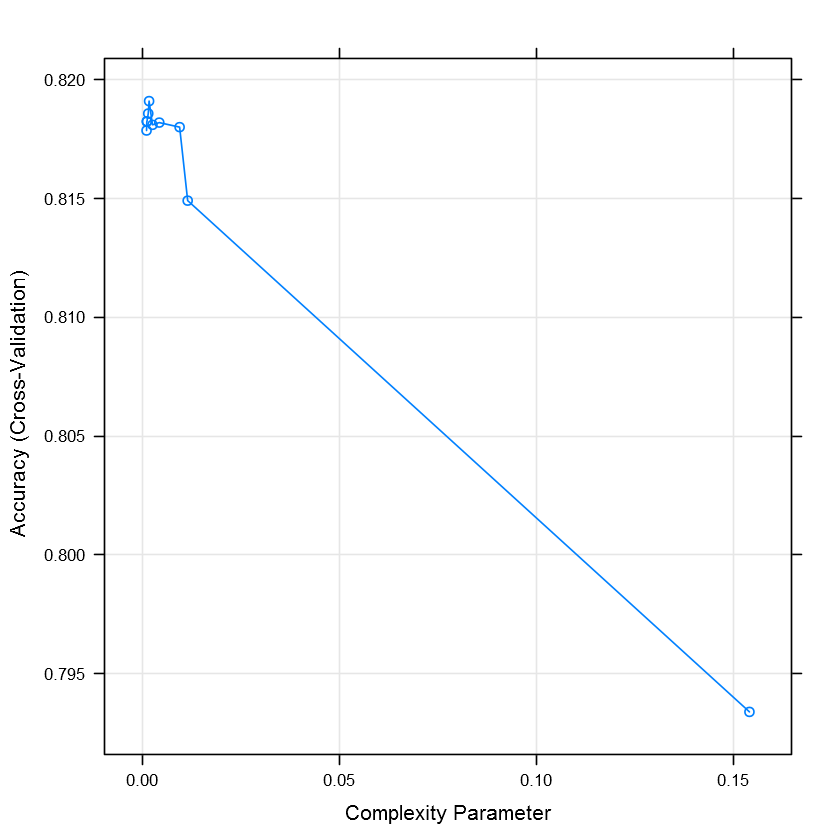

In [58]:
# Plot de los arboles de decisión y su precisión
plot(treeFit)

########################################################################################################################

# 6) Evaluación

In [60]:
metricas

,accuracy,error,sensitivity,specificity,posPredValue,negPredValue
knn,0.8138682,0.1861318,0.9547724,0.3175879,0.8313043,0.6659642
Decisión Tree,0.8192021,0.1807979,0.9569125,0.3341709,0.8350349,0.6876939
Random Forest,0.8185354,0.1814646,0.9619061,0.3135678,0.8315244,0.7003367
SVM,0.8182020,0.1817980,0.9601940,0.3180905,0.8321998,0.6940789


A lo largo del documento se ha venido presentando el análisis, la evaluación y las conclusiones de los cálculos realizados. A nivel general se puede definir que:

- La mayoría de las técnicas muestran una precisión similar que ronda el 81%, pero el metodo de "Decisión Tree" fue el que mejor precisión obtuvo con un 81,92%.

- Observando los datos de la tabla anterior, se puede ver por medio de la columna Specificity que los modelos son buenos para clasificar a los clientes como true positive, es decir, que clasifica que van a pagar cuando en realidad van a pagar, mientras que en la columna specificity se ve que los modelos son muy debiles para clasificar los false positive o personas que no van a pagar cuando realmente no pagarán, Esto se  puede deber a un problema de Balanceo en las proporciones de las categorias de la variable clasificadora.

- Los datos tienen un desbalanceo, el cual es notorio en los resultados arrojados por las matrices de confusión, en donde se evidencia que los modelos son buenos para predecir que un cliente va a pagar cuando realmente lo hara, pero son debiles para predecir que un cliente va a pagar cuando realmente no lo hara. Las posibles soluciones a este problema serian utilizar técnicas de balanceo, en donde se eliminana registros o se agregan duplicados según sea el caso que más convenga.